In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union

In [2]:
M = 1.989e30 #kg
G = 6.6741e-11 # m^3/kg/s^2
AU = 149597870700 #m

In [3]:
x0 = np.array([0, 0.586]) * AU # m
v0 = np.array([54600, 0]) # m/s


In [4]:
def a(r: np.ndarray):
    return -G * M * r / np.power(r.dot(r), 3/2)
    

In [5]:
class Solver:
    def __init__(self, tmax: int, dt: float):
        self.x = None
        self.v = None
        self.t = None
        self.dt = None
        self.update_params(tmax, dt)

    def update_params(self, tmax: int, dt: float):
        num = int(tmax//dt)
        self.x = np.zeros((num, 2))
        self.v = np.zeros((num, 2))
        self.t = np.linspace(0, tmax, num=num)
        self.dt = dt

    def set_new_values(self, x: np.ndarray, v: np.ndarray, i):
        self.x[i] = x
        self.v[i] = v

    def get_new_values(self, i: int):
        return self.x[i], self.v[i]

    def calculate(self):
        for i in range(len(self.t)):
            if i == 0:
                self.set_new_values(x0, v0, 0)
                continue
            x, y = self.get_next_step(i-1)
            self.set_new_values(x, y, i)

In [6]:
class Euler(Solver):
    def __init__(self, tmax: int, dt: float):
        super().__init__(tmax, dt)

    def get_next_step(self, i: int):
        last_x = self.x[i]
        last_v = self.v[i]
        new_x = last_x + last_v * self.dt
        new_y = last_v + a(last_x) * self.dt
        return new_x, new_y

In [7]:
class Plotter:
    def __init__(self, solver: Euler, dir: str):
        self.solver = solver
        self.dir = dir

    def plot(self, filename: str = "funcT"):
        plt.plot(self.solver.x[0], self.solver.x[1])
        plt.show()



In [8]:
solv = Euler(10000000000, 2000)
solv.calculate()

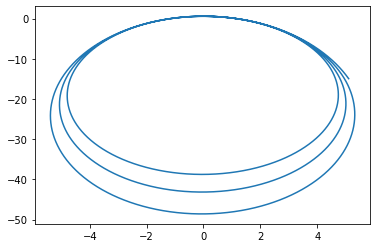

In [9]:
plt.plot(solv.x[:,0]/AU, solv.x[:,1]/AU)